# Introduction

Here we describe our analysis of the wikipedia traffic data.

# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (FunctionTransformer, StandardScaler, PolynomialFeatures)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import (LinearRegression, Lasso)
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

In [2]:
def smape(Y_predict, Y_test):
    if Y_predict.shape != Y_test.shape:
        raise ValueError('Expecting Y_predict shape == Y_test.shape, but NOT equal')
        return
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

# Getting and Cleaning Data

We clean the data of NaN values by simply replacing each NaN value with the mean value of number of visits for each sample.

In [3]:
# Get the time series data.
data_df = pd.read_csv('train_2.csv')

print('data_df.shape = ', data_df.shape)
data_df.head()

data_df.shape =  (145063, 794)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [4]:
# Now fix NaN values in data_df.

means = data_df.drop('Page', axis = 1).mean(axis = 1)
means.fillna(0, inplace = True)

for column in data_df.columns:
    
    data_df[column].fillna(means, inplace = True)

data_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


# Time Features

Let's investigate using features derived from the time series for predicting future values of the time series.

## Splitting the Data

First, we need to split the time series data into past and future values.

In [5]:
futureT = 62
pastT = len(data_df.columns) - 1 - futureT # Remember to account for page column
future_cols = data_df.columns[-futureT:]
past_cols = data_df.columns[:-futureT]

X_df = data_df.iloc[:, :-futureT]
Y_df = data_df.iloc[:, -futureT:]

X_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,28.0,26.0,29.0,21.0,23.0,23.0,32.0,34.0,21.0,24.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,24.0,18.0,193.0,26.0,62.0,127.0,104.0,20.0,29.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,8.0,7.0,3.0,5.0,4.0,4.0,5.0,5.0,0.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,12.0,17.0,15.0,12.0,11.0,12.0,10.0,22.0,21.0,30.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,12.0,12.0,17.0,16.0,12.0,10.0,21.0,14.0,9.0,12.0


Now let's split into training, validation, and test sets.

In [6]:
indices = {}
indices['tv'], indices['test'], dummy1, dummy2 = train_test_split(X_df.index, Y_df.index, test_size = 0.33, random_state = 31)
indices['train'], indices['valid'], dummy1, dummy2 = train_test_split(indices['tv'], indices['tv'], 
                                                                      test_size = 0.33, random_state = 43)

#indices = train_test_split(X_df.index, Y_df.index, test_size = 0.33, random_state = 31)
X = {}
Y = {}

for name in ['train', 'valid', 'tv', 'test']:
    X[name] = X_df.drop('Page', axis = 1).loc[indices[name]]
    Y[name] = Y_df.loc[indices[name]]

for name in ['train', 'valid', 'test']:
    print('X ' + name + ' shape = ', X[name].shape,
          '\tY ' + name + ' shape = ', Y[name].shape)
    
X['train'].head()

X train shape =  (65118, 731) 	Y train shape =  (65118, 62)
X valid shape =  (32074, 731) 	Y valid shape =  (32074, 62)
X test shape =  (47871, 731) 	Y test shape =  (47871, 62)


,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30
122897,1879.000000,5639.000000,9545.000000,8663.000000,20317.000000,18077.000000,10069.000000,8128.000000,5766.000000,5538.000000,...,1137.0,1874.0,1097.0,1298.0,1617.0,1299.0,1173.0,1147.0,1068.0,952.0
138730,16.000000,15.000000,22.000000,26.000000,15.000000,22.000000,21.000000,19.000000,22.000000,21.000000,...,19.0,16.0,26.0,29.0,22.0,22.0,27.0,31.0,27.0,18.0
55662,175.514599,175.514599,175.514599,175.514599,175.514599,175.514599,175.514599,175.514599,175.514599,175.514599,...,59.0,43.0,54.0,79.0,97.0,53.0,68.0,61.0,61.0,74.0
101069,740.498525,740.498525,740.498525,740.498525,740.498525,740.498525,740.498525,740.498525,740.498525,740.498525,...,255.0,244.0,497.0,362.0,303.0,264.0,289.0,230.0,265.0,490.0
53806,340.000000,181.000000,438.000000,399.000000,325.000000,493.000000,1481.000000,294.000000,398.000000,372.000000,...,90.0,88.0,98.0,168.0,106.0,76.0,98.0,90.0,76.0,243.0


## Simple Benchmark Using Means

Let us develop a simple benchmark by just looking at a linear model based on the mean X value.

In [7]:
epsilon = 1e-6

model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('linear', LinearRegression()) ])
model.fit(X['train'], Y['train'])
Y['predict'] = model.predict(X['valid'])
newsmape = smape(Y['predict'] + epsilon, Y['valid'])

results_df = pd.DataFrame([newsmape], columns = ['smape'], index = ['LinearMeans'])
results_df

,smape
LinearMeans,102.319842


## Transforming the data

Let's investigate how the mean Y value depends on the mean X value for the training data set.

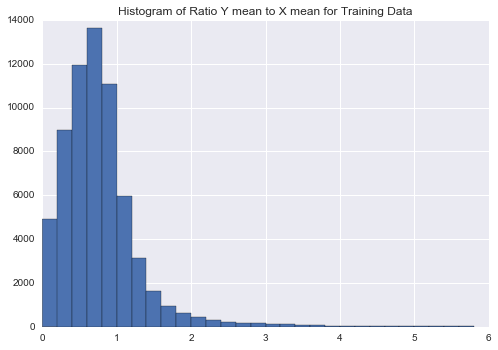

In [8]:
# Get histogram of mean Y values for training data.
epsilon = 1e-6

bins = np.arange(0, 6, 6 / 30)
values = Y['train'].mean(axis = 1) / (epsilon + X['train'].mean(axis = 1))
values.hist(bins = bins)
plt.title('Histogram of Ratio Y mean to X mean for Training Data')
plt.show()

So we see that the distribution of the ratio of the means are lop-sided. We can fix the lop sidedness using a logarithmic transform of the form z = np.log(C + x) for C a parameter. Now, note that we are using a SMAPE scoring function which prefers over estimates to under estimates. So, even for a Gaussian distribution of ratios about 1, it isn't ideal to just go with the average value; that is the reduction of L2 norms isn't ideal for optimizing a SMAPE score. We can try to fix this by adjusting C.

So let us search over values of C such that guessing the average value of the transform gives a good estimate. We use a linear model for the log values.

1 ,4 ,7 ,10 ,13 ,16 ,19 ,22 ,25 ,28 ,31 ,34 ,37 ,

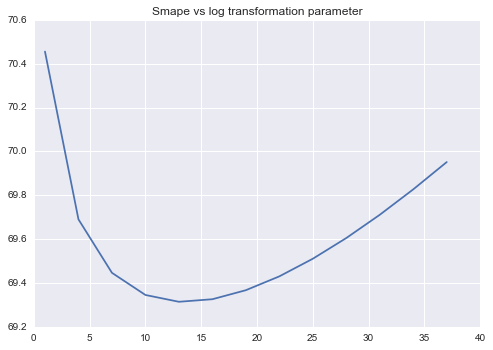

In [9]:
log_predictor = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                           ('linear', LinearRegression()) ])
search = np.arange(1, 40, 3)

results = []
for var in search:
    
    X['train_l'] = np.log(var + X['train'])
    Y['train_l'] = np.log(var + Y['train'])
    X['valid_l'] = np.log(var + X['valid'])

    log_predictor.fit(X['train_l'], Y['train_l'])
    Y['predict_l'] = log_predictor.predict(X['valid_l'])
    Y['predict'] = -var + np.exp(Y['predict_l'])
    newsmape = smape(epsilon + Y['predict'], Y['valid'])
    results.append(newsmape)
    print(var, ',', end = '')
    
plt.plot(search, results)
plt.title('Smape vs log transformation parameter')
plt.show()

So the optimal log transformation parameter seems to be about 12.5. We will use the transform z = np.log(12.5 + x). Let's construct the transforms of the different time series.

In [10]:
param = 12.5

for name in ['train', 'valid', 'test']:
    X[name + '_l'] = np.log(param + X[name])
    Y[name + '_l'] = np.log(param + Y[name])

Let's investigate how well the mean of the Y values correlates with X values.

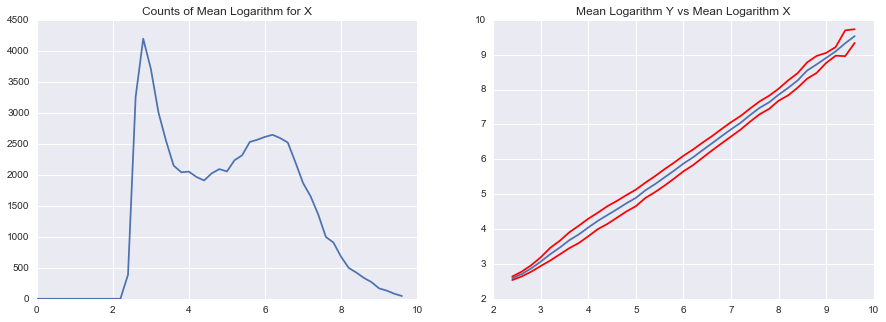

In [11]:
bins = np.arange(0, 10, 10 / 50)
cut = pd.cut(X['train_l'].mean(axis = 1), bins = bins)

plt.figure(figsize = (15, 5))
plt.subplot(121)
counts = Y['train_l'].mean(axis = 1).groupby(cut).count()
plt.plot(bins[:-1], counts.values)
plt.title('Counts of Mean Logarithm for X')

plt.subplot(122)
means = Y['train_l'].mean(axis = 1).groupby(cut).mean()
stds = Y['train_l'].std(axis = 1).groupby(cut).std()
plt.plot(bins[:-1], means.values)
plt.plot(bins[:-1], means.values + stds.values, color = 'red')
plt.plot(bins[:-1], means.values - stds.values, color = 'red')
plt.title('Mean Logarithm Y vs Mean Logarithm X')
plt.show()

So we see that there is a good linear relationship between the two. So let us now try a simple linear model.

In [12]:
log_predictor = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                           ('linear', LinearRegression()) ])

log_predictor.fit(X['train_l'], Y['train_l'])
Y['predict_l'] = log_predictor.predict(X['valid_l'])
Y['predict'] = -param + np.exp(Y['predict_l'])
newsmape = smape(epsilon + Y['predict'], Y['valid'])
print('smape = ', newsmape)

results_df.loc['LinearMeansLog'] = newsmape
Y['predict_l'] = log_predictor.predict(X['train_l'])
errors = {'LinearMeansLog' : (Y['predict_l'] - Y['train_l']).mean(axis = 1) }
results_df

smape =  69.3158584828


,smape
LinearMeans,102.319842
LinearMeansLog,69.315858


### Z transform

Now we consider looking at a different transform.

50 ,75 ,100 ,125 ,150 ,175 ,200 ,225 ,

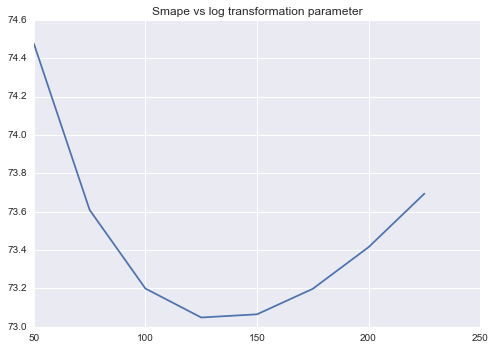

In [13]:
def ztransform1(Y, param):
    return 1 / (param + Y)

# inverse transformation, Y = inverseZ(Z)

def inverseZ1(Z, param):
    return -param + 1 / Z

Z1_predictor = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                           ('linear', LinearRegression()) ])

search = np.arange(50, 250, 25)

results = []
for var in search:
    
    X['train_z1'] = ztransform1(X['train'], var)
    Y['train_z1'] = ztransform1(Y['train'], var)
    X['valid_z1'] = ztransform1(X['valid'], var)

    Z1_predictor.fit(X['train_z1'], Y['train_z1'])
    Y['predict_z1'] = Z1_predictor.predict(X['valid_z1'])
    Y['predict'] = inverseZ1(Y['predict_z1'], var)
    newsmape = smape(epsilon + Y['predict'], Y['valid'])
    results.append(newsmape)
    print(var, ',', end = '')
    
plt.plot(search, results)
plt.title('Smape vs log transformation parameter')
plt.show()

In [14]:
param_z1 = 125

for name in ['train', 'valid', 'test']:
    X[name + '_z1'] = ztransform1(X[name], param_z1)
    Y[name + '_z1'] = ztransform1(Y[name], param_z1)

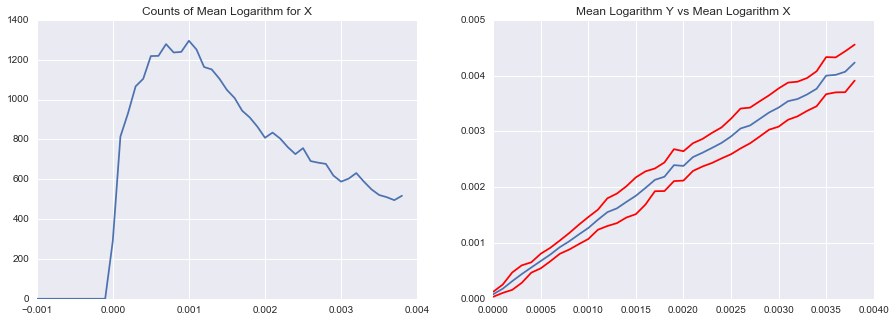

In [15]:
bins = np.arange(-1e-3, 4e-3, 5e-3 / 50)
cut = pd.cut(X['train_z1'].mean(axis = 1), bins = bins)

plt.figure(figsize = (15, 5))
plt.subplot(121)
counts = Y['train_z1'].mean(axis = 1).groupby(cut).count()
plt.plot(bins[:-1], counts.values)
plt.title('Counts of Mean Logarithm for X')

plt.subplot(122)
means = Y['train_z1'].mean(axis = 1).groupby(cut).mean()
stds = Y['train_z1'].std(axis = 1).groupby(cut).std()
plt.plot(bins[:-1], means.values)
plt.plot(bins[:-1], means.values + stds.values, color = 'red')
plt.plot(bins[:-1], means.values - stds.values, color = 'red')
plt.title('Mean Logarithm Y vs Mean Logarithm X')
plt.show()

250 ,275 ,300 ,325 ,350 ,375 ,400 ,425 ,

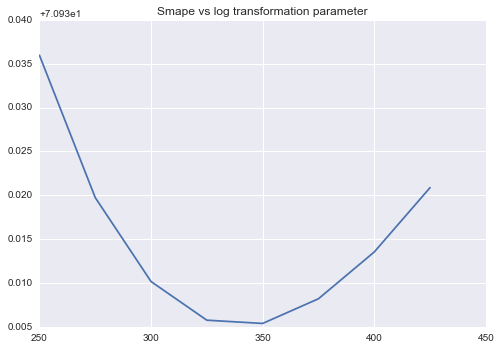

In [16]:
def ztransform2(Y, param):
    return (np.sqrt(Y) - np.sqrt(param)) / np.sqrt(Y + param)

def inverseZ2(Z, param):
    Z2 = np.minimum(Z, 1 - epsilon)
    Z2 = np.maximum(Z2, -1 + epsilon)
    result = -1 - Z2 * np.sqrt(2 - Z2**2)
    result = result / (Z2**2 - 1)
    result = param * result**2
    return result

Z2_predictor = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                           ('linear', LinearRegression()) ])

search = np.arange(250, 450, 25)

results = []
for var in search:
    
    X['train_z2'] = ztransform2(X['train'], var)
    Y['train_z2'] = ztransform2(Y['train'], var)
    X['valid_z2'] = ztransform2(X['valid'], var)

    Z2_predictor.fit(X['train_z2'], Y['train_z2'])
    Y['predict_z2'] = Z2_predictor.predict(X['valid_z2'])
    Y['predict'] = inverseZ2(Y['predict_z2'], var)
    newsmape = smape(epsilon + Y['predict'], Y['valid'])
    results.append(newsmape)
    print(var, ',', end = '')
    
plt.plot(search, results)
plt.title('Smape vs log transformation parameter')
plt.show()

In [17]:
param_z2 = 335

for name in ['train', 'valid', 'test']:
    X[name + '_z2'] = ztransform2(X[name], param_z2)
    Y[name + '_z2'] = ztransform2(Y[name], param_z2)

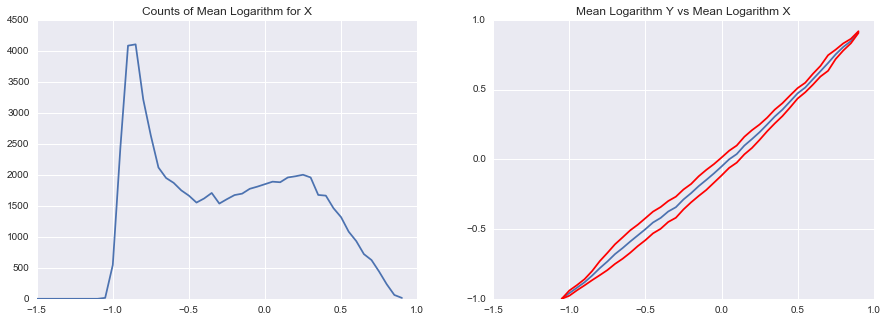

In [18]:
bins = np.arange(-1.5, 1, 2.5 / 50)
cut = pd.cut(X['train_z2'].mean(axis = 1), bins = bins)

plt.figure(figsize = (15, 5))
plt.subplot(121)
counts = Y['train_z2'].mean(axis = 1).groupby(cut).count()
plt.plot(bins[:-1], counts.values)
plt.title('Counts of Mean Logarithm for X')

plt.subplot(122)
means = Y['train_z2'].mean(axis = 1).groupby(cut).mean()
stds = Y['train_z2'].std(axis = 1).groupby(cut).std()
plt.plot(bins[:-1], means.values)
plt.plot(bins[:-1], means.values + stds.values, color = 'red')
plt.plot(bins[:-1], means.values - stds.values, color = 'red')
plt.title('Mean Logarithm Y vs Mean Logarithm X')
plt.show()

## Adding in the Mean of Last Window of Time

Now we look at adding in the mean of the X values for some last window of time of a certain size. Note, we should expect this mean to be similar to the mean value for the entire time series of X values. So we actually create a new feature based on this difference. First, let's investigate how the errors in our previous model depend on the window size.

1 ,101 ,201 ,301 ,401 ,

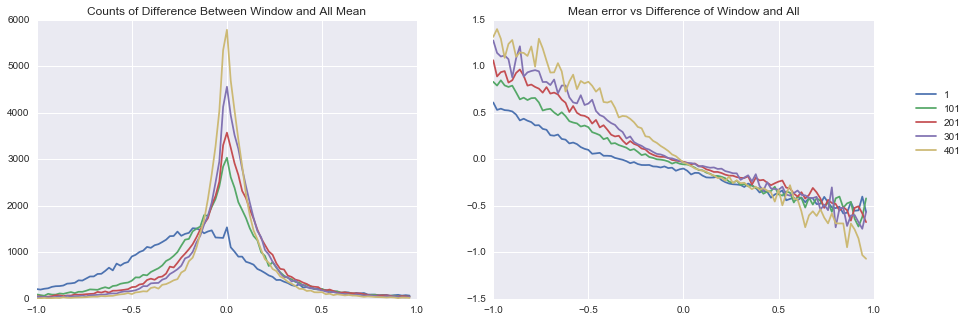

In [19]:
bins = np.arange(-1, 1, 1/50)

search = np.arange(1, 451, 100)

means = []
counts = []

for var in search:
    windmean = X['train_l'].iloc[:, -var:].mean(axis = 1)
    cut = pd.cut(windmean - X['train_l'].mean(axis = 1), bins = bins)

    newcount = errors['LinearMeansLog'].groupby(cut).count().values
    counts.append(newcount)
    newmean = errors['LinearMeansLog'].groupby(cut).mean().values
    means.append(newmean)
    print(var, ',', end = '')
  
plt.figure(figsize = (15, 5))
plt.subplot(121)
counts = np.stack(counts, axis = -1)
plt.plot(bins[:-1], counts)
plt.title('Counts of Difference Between Window and All Mean')

plt.subplot(122)
means = np.stack(means, axis = -1)
plt.plot(bins[:-1], means)
plt.title('Mean error vs Difference of Window and All')
plt.legend(search, loc = (1.1, 0.5))
plt.show()

There appears to be a linear correlation between the errors and the positive and negative parts of the difference. That is, there is a difference for when the window mean is greater or less than the mean of the entire time series.

Let us set up a linear model and search over the optimal window size.

In [20]:
# First set up feature transformation.

def newfeatures(X, windowSize) :
    features = [X.mean(axis = 1)]
    difference = X[:, -windowSize:].mean(axis = 1) - features[0]
    difference = np.stack([difference, np.zeros(difference.shape)])
    
    newfeature = np.amin(difference, axis = 0)
    features.append(newfeature)
    
    newfeature = np.amax(difference, axis = 0)
    features.append(newfeature)
    
    features = np.stack(features, axis = -1)
    return features

features = {'windowMeanModel' : newfeatures}
features['windowMeanModel'](X['train_l'].values, 100).shape

(65118, 3)

1 ,4 ,7 ,10 ,13 ,16 ,19 ,22 ,25 ,28 ,31 ,34 ,37 ,40 ,43 ,46 ,49 ,52 ,55 ,58 ,

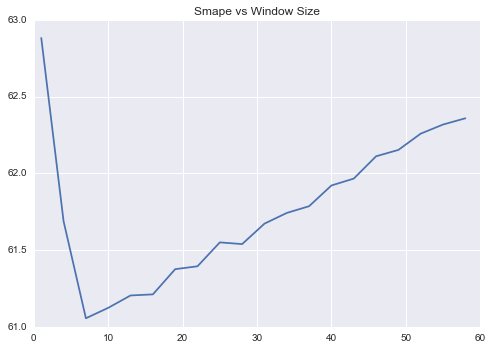

In [21]:
# Search over the window size.

log_predictor = Pipeline([ ('features', FunctionTransformer(features['windowMeanModel'])),
                           ('linear', LinearRegression()) ])
search = np.arange(1, 60, 3)

results = []
for var in search:
    
    log_predictor.set_params(features__kw_args = {'windowSize' : var})
    log_predictor.fit(X['train_l'], Y['train_l'])
    Y['predict_l'] = log_predictor.predict(X['valid_l'])
    Y['predict'] = -param + np.exp(Y['predict_l'])
    newsmape = smape(epsilon + Y['predict'], Y['valid'])
    results.append(newsmape)
    print(var, ',', end = '')
    
plt.plot(search, results)
plt.title('Smape vs Window Size')
plt.show()

There seems to be a sudden jump for window size less than 10. Let us avoid this sudden change in model behavior by picking a value above there. Let's take a window size of 31, which is half of the window size we wish to predict.

In [22]:
windowSize = 31

log_predictor = Pipeline([ ('features', FunctionTransformer(features['windowMeanModel'],
                                                            kw_args = {'windowSize' : 31} )),
                           ('linear', LinearRegression()) ])

log_predictor.fit(X['train_l'], Y['train_l'])
Y['predict_l'] = log_predictor.predict(X['valid_l'])
Y['predict'] = -param + np.exp(Y['predict_l'])
newsmape = smape(epsilon + Y['predict'], Y['valid'])
print('smape = ', newsmape)

Y['predict_l'] = log_predictor.predict(X['train_l'])
errors['windowMean'] = (Y['predict_l'] - Y['train_l']).mean(axis = 1)
results_df.loc['windowMean'] = newsmape
results_df

smape =  61.6722150646


,smape
LinearMeans,102.319842
LinearMeansLog,69.315858
windowMean,61.672215


## Polynomial Change

Now we will add in more features based on the linear growth and higher order behavior of the time series. That is, we construct an orthonormal basis of features based on different degrees of polynomial change in time. We do this for both the entire time series and also for the last window of time. Then we break the comonents into positive and negative parts for the difference between the window components and the appropriate conversion of the entire time series components. Note that they shouldn't be compared directly.

In [23]:
# Function to orthnormalize features basis. Basis should be of shape (nFeatures, nTimes).

def orthonormalize(Basis):
    nFeatures, nTimes = Basis.shape
    for i in range(nFeatures):
        for feature in Basis[:i]:
            Basis[i] -= np.dot(Basis[i], feature) * feature
        Basis[i] /= np.linalg.norm(Basis[i])
    return Basis

def newfeatures2(X, windowSize, degree):
    nSamples, nTimes = X.shape
    all_basis = [np.full(nTimes, 1, dtype = 'float32')]
    window_basis = [np.full(windowSize, 1, dtype = 'float32')]
    for i in range(degree):
        all_basis.append(all_basis[i] * np.arange(nTimes))
        window_basis.append(window_basis[i] * np.arange(windowSize))
    all_basis = np.stack(all_basis)
    all_basis = orthonormalize(all_basis)
    window_basis = np.stack(window_basis)
    window_basis = orthonormalize(window_basis)
    
    all_poly = np.dot(X, all_basis.T)
    window_poly = np.dot(X[:, -windowSize:], window_basis.T)
    all_conv = np.dot(all_poly, all_basis)[:, -windowSize:]
    all_conv = np.dot(all_conv, window_basis.T)
    difference = window_poly - all_conv
    difference = np.stack([difference, np.zeros(difference.shape)])
    pos_features = np.amax(difference, axis = 0)
    neg_features = np.amin(difference, axis = 0)
    
    features = np.concatenate([all_poly, pos_features, neg_features], axis = 1)
    return features
    
print(newfeatures2(X['train'].values, 31, 3).shape)

features['polymodel'] = newfeatures2

(65118, 12)


0 ,1 ,2 ,3 ,4 ,5 ,7 ,9 ,11 ,13 ,15 ,17 ,19 ,21 ,23 ,

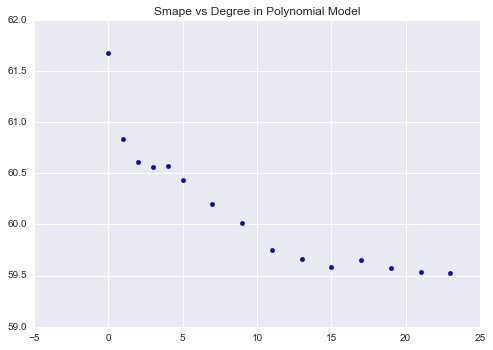

In [24]:
# Now do a search on degree size.

search = np.arange(0, 5)
search = np.concatenate([search, np.arange(5, 25, 2)])

log_predictor = Pipeline([ ('features', FunctionTransformer(features['polymodel'])),
                           ('linear', LinearRegression()) ])

results = []
for var in search:
    
    log_predictor.set_params(features__kw_args = {'windowSize' : 31,
                                                  'degree' : var})
    log_predictor.fit(X['train_l'], Y['train_l'])
    Y['predict_l'] = log_predictor.predict(X['valid_l'])
    Y['predict'] = -param + np.exp(Y['predict_l'])
    newsmape = smape(epsilon + Y['predict'], Y['valid'])
    results.append(newsmape)
    print(var, ',', end = '')
    
plt.scatter(search, results)
plt.title('Smape vs Degree in Polynomial Model')
plt.show()

Let's see what some of these polynomial basis look like.

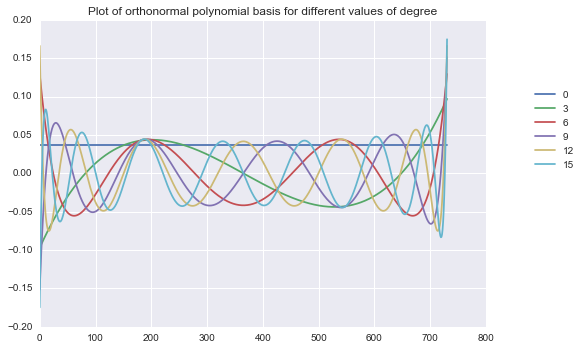

In [25]:
degree = 15
poly_basis = [np.full(X['train'].shape[1], 1.0)]
for i in range(degree):
    newpoly = poly_basis[i] * np.arange(X['train'].shape[1])
    poly_basis.append(newpoly)
poly_basis = np.stack(poly_basis)
poly_basis = orthonormalize(poly_basis)
plt.plot(poly_basis[::3,:].T)
plt.legend([str(i) for i in range(0, degree+1, 3)], loc = (1.1, 0.5))
plt.title('Plot of orthonormal polynomial basis for different values of degree')
plt.show()

We see that the optimal value is given by degree 15. However, the gain isn't very large. If we desire a smaller number of features, then degree 3 seems like it will be optimal.

In [26]:
# Get result for degree 3.

log_predictor = Pipeline([ ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 3})),
                           ('linear', LinearRegression()) ])

log_predictor.fit(X['train_l'], Y['train_l'])
Y['predict_l'] = log_predictor.predict(X['valid_l'])
Y['predict'] = -param + np.exp(Y['predict_l'])
newsmape = smape(epsilon + Y['predict'], Y['valid'])

Y['predict_l'] = log_predictor.predict(X['train_l'])
errors['polyDegree3'] = (Y['predict_l'] - Y['train_l']).mean(axis = 1)

results_df.loc['polyDegree3'] = newsmape
results_df

,smape
LinearMeans,102.319842
LinearMeansLog,69.315858
windowMean,61.672215
polyDegree3,60.561625


In [27]:
# Get result for degree 15.

log_predictor = Pipeline([ ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 15})),
                           ('linear', LinearRegression()) ])

log_predictor.fit(X['train_l'], Y['train_l'])
Y['predict_l'] = log_predictor.predict(X['valid_l'])
Y['predict'] = -param + np.exp(Y['predict_l'])
newsmape = smape(epsilon + Y['predict'], Y['valid'])
results_df.loc['polyDegree15'] = newsmape

Y['predict_l'] = log_predictor.predict(X['train_l'])
errors['polyDegree15'] = (Y['predict_l'] - Y['train_l']).mean(axis = 1)

Y['predict'] = -param + np.exp(Y['predict_l'])
errors['polyDegree15_smape'] = []
for predict, actual in zip(Y['predict'], Y['train'].values):
    newsmape = smape(epsilon + predict.reshape(1, -1), actual.reshape(1,-1))
    errors['polyDegree15_smape'].append(newsmape)
errors['polyDegree15_smape'] = np.stack(errors['polyDegree15_smape'])

results_df

,smape
LinearMeans,102.319842
LinearMeansLog,69.315858
windowMean,61.672215
polyDegree3,60.561625
polyDegree15,59.585536


## Some Non-linear Models

### Decision Tree Regressor

0.0002 , 0.0004 , 0.0006 , 0.0008 , 0.001 , 0.0012 , 

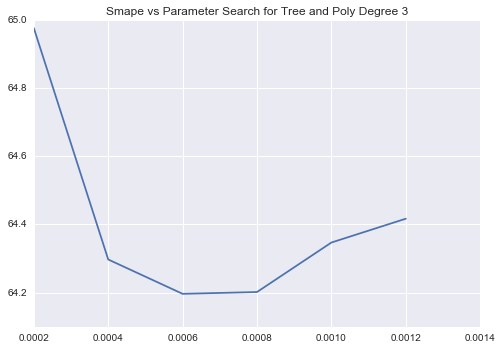

In [28]:
# Do a search of min split for degree 3.

log_predictor = Pipeline([ ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 3})),
                           ('tree', DecisionTreeRegressor()) ])

search = 2 * 10**-4 * np.arange(1.0, 7.0, 1.0)
results = []

for var in search:
    
    log_predictor.set_params(tree__min_samples_leaf = var)
    log_predictor.fit(X['train_l'], Y['train_l'])
    Y['predict_l'] = log_predictor.predict(X['valid_l'])
    Y['predict'] = -param + np.exp(Y['predict_l'])
    newsmape = smape(epsilon + Y['predict'], Y['valid'])
    results.append(newsmape)
    print(var, ', ', end = '')
    
plt.plot(search, results)
plt.title('Smape vs Parameter Search for Tree and Poly Degree 3')
plt.show()

0.0002 , 0.0004 , 0.0006 , 0.0008 , 0.001 , 0.0012 , 

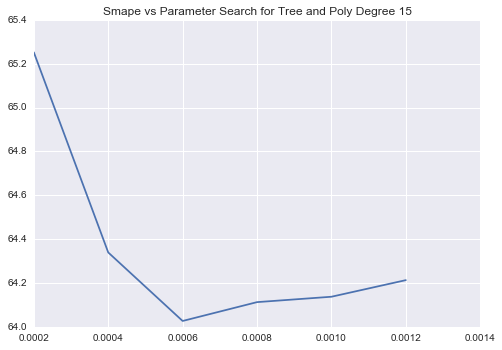

In [29]:
# Do a search of max depth for degree 15.

log_predictor = Pipeline([ ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 15})),
                           ('tree', DecisionTreeRegressor()) ])

search = 2 * 10**-4 * np.arange(1.0, 7.0, 1.0)
results = []

for var in search:
    
    log_predictor.set_params(tree__min_samples_leaf = var)
    log_predictor.fit(X['train_l'], Y['train_l'])
    Y['predict_l'] = log_predictor.predict(X['valid_l'])
    Y['predict'] = -param + np.exp(Y['predict_l'])
    newsmape = smape(epsilon + Y['predict'], Y['valid'])
    results.append(newsmape)
    print(var, ', ', end = '')
    
plt.plot(search, results)
plt.title('Smape vs Parameter Search for Tree and Poly Degree 15')
plt.show()

### Multi-Layer Perceptron

7.0 , 8.0 , 9.0 , 10.0 , 

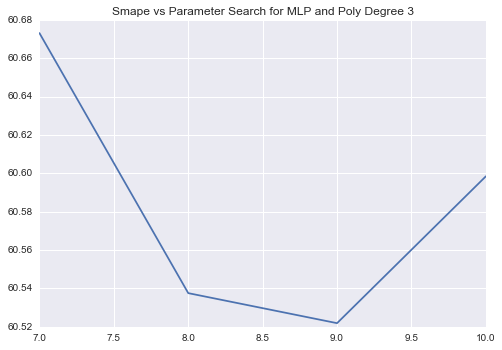

In [69]:
# Do a search of alpha for degree 3.

log_predictor = Pipeline([ ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 3})),
                           ('scaler', StandardScaler()),
                           ('neural', MLPRegressor(hidden_layer_sizes = (30, 30, 30),
                                                   tol = 1e-3,
                                                   random_state = 123)) ])

search = np.arange(7.0, 11.0, 1.0)
results = []

for var in search:
    
    log_predictor.set_params(neural__alpha = var)
    log_predictor.fit(X['train_l'], Y['train_l'])
    Y['predict_l'] = log_predictor.predict(X['valid_l'])
    Y['predict'] = -param + np.exp(Y['predict_l'])
    newsmape = smape(epsilon + Y['predict'], Y['valid'])
    results.append(newsmape)
    print(var, ', ', end = '')
    
plt.plot(search, results)
plt.title('Smape vs Parameter Search for MLP and Poly Degree 3')
plt.show()

7.0 , 8.0 , 9.0 , 10.0 , 11.0 , 12.0 , 

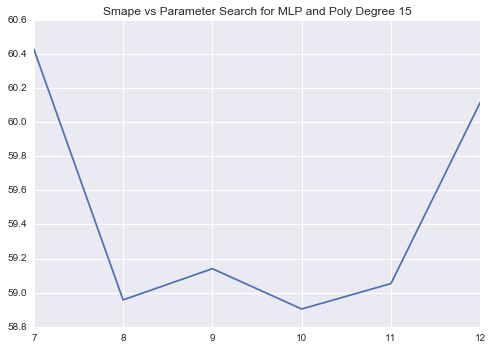

In [72]:
# Do a search of alpha for degree 15.

log_predictor = Pipeline([ ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 15})),
                           ('scaler', StandardScaler()),
                           ('neural', MLPRegressor(hidden_layer_sizes = (30, 30, 30),
                                                   tol = 1e-3,
                                                   random_state = 123)) ])

search = np.arange(7.0, 13.0, 1.0)
results = []

for var in search:
    
    log_predictor.set_params(neural__alpha = var)
    log_predictor.fit(X['train_l'], Y['train_l'])
    Y['predict_l'] = log_predictor.predict(X['valid_l'])
    Y['predict'] = -param + np.exp(Y['predict_l'])
    newsmape = smape(epsilon + Y['predict'], Y['valid'])
    results.append(newsmape)
    print(var, ', ', end = '')
    
plt.plot(search, results)
plt.title('Smape vs Parameter Search for MLP and Poly Degree 15')
plt.show()

# Page Features

## Breaking Up Page Data

Now we break up the Page data into the name of the page, the wikipedia project, the access, and the agent. We store these features in a separate dataframe, page_df.

In [32]:
# Let's get information from Page data.

urlRegEx = '[^._]+[.]\w*wiki\w*[.][^_]+'

# Extract info from page

pageInfo = []

for pageStr in data_df.Page.values:
    midSplit = re.split('[_](' + urlRegEx + ')[_]', pageStr)
    thisPageInfo = midSplit[:2]
    midSplit = re.split('[_]', midSplit[2])
    thisPageInfo.extend(midSplit)
    
    pageInfo.append(thisPageInfo)
    
# Do a transpose, now in shape nInfo, nSamples

pageInfo = [[pageInfo[j][i] for j in range(len(pageInfo))] for i in range(len(pageInfo[0]))]

toInfoIndex = {'name' : 0, 'project' : 1, 'access' : 2, 'agent' : 3}
colNames = ['name', 'project', 'access', 'agent']

page_df = pd.DataFrame(data = pageInfo[0], columns = ['name'])

# Convert info to numerical

for i in range(1, 4):
    name = colNames[i]
    infoCol = np.array(pageInfo[i])
    infoCol_vals = np.unique(infoCol)
    infoCol_map = dict(zip(infoCol_vals, np.arange(len(infoCol_vals))))
    infoCol = [infoCol_map[x] for x in infoCol]
    page_df[name] = infoCol

page_df.head()

,name,project,access,agent
0,2NE1,9,0,3
1,2PM,9,0,3
2,3C,9,0,3
3,4minute,9,0,3
4,52_Hz_I_Love_You,9,0,3


We will be interested in seeing how the errors of our previous model (for the training data) depend on the our new features. So we will put the errors into a new dataframe.

In [33]:
errors_df = pd.DataFrame(errors['polyDegree15'], columns = ['errors'])
errors_df['errors_smape'] = errors['polyDegree15_smape']
errors_df.head()

,errors,errors_smape
122897,-0.507432,94.657936
138730,0.135648,32.622192
55662,-0.078010,21.345334
101069,0.180461,42.100475
53806,-0.690961,146.353427


## Name Features

Now we look at creating features from the names.

### Number of Words in Name

Let's count the number of words in each name by counting the number of appearances of the character '_'.

In [34]:
# Let's count number of words in name.

numWords = []

for name in page_df['name']:
    num = len(re.split(r'_', name))
    numWords.append(num)
        
numWords = np.array(numWords)

page_df['numWords'] = numWords

Let's look at a histogram of word counts and how mean of log ratios depends on word counts.

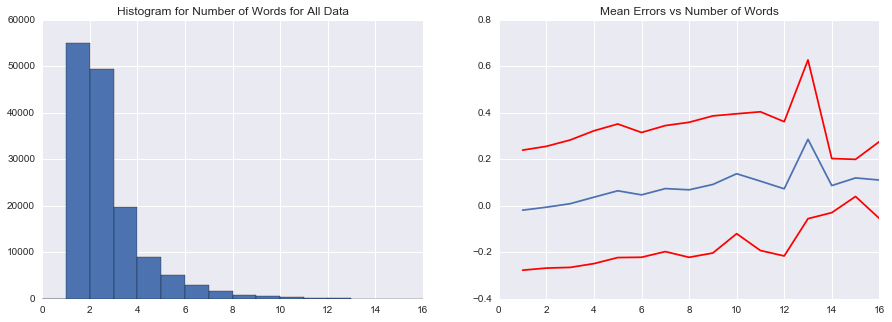

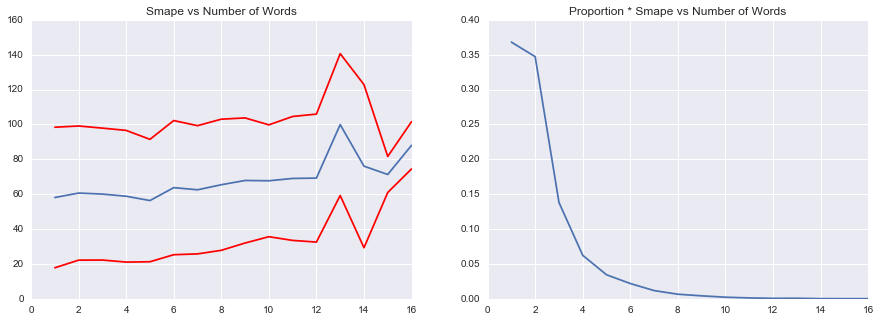

In [35]:
# Let's look at statistics for number of words and how the errors of previous models depend on the number
# of words.

doublefigsize = (15, 5)

plt.figure(figsize = doublefigsize)
plt.subplot(121)
bins = np.arange(17)
page_df['numWords'].hist(bins = bins)
plt.title('Histogram for Number of Words for All Data')

errors_df['numWords'] = page_df.loc[indices['train'], 'numWords']
cut = pd.cut(errors_df.numWords, bins)
grouped_df = errors_df.groupby(cut)

means = grouped_df.mean().errors
stds = grouped_df.std().errors
plt.subplot(122)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Mean Errors vs Number of Words')
plt.show()

counts = grouped_df.count().errors_smape
means = grouped_df.mean().errors_smape
stds = grouped_df.std().errors_smape
plt.figure(figsize = doublefigsize)
plt.subplot(121)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Smape vs Number of Words')

plt.subplot(122)
plt.plot(bins[1:], means * counts / np.sum(counts * means))
plt.title('Proportion * Smape vs Number of Words')
plt.show()

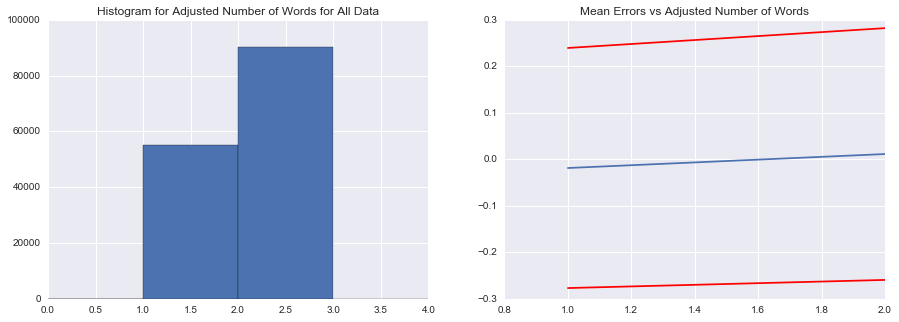

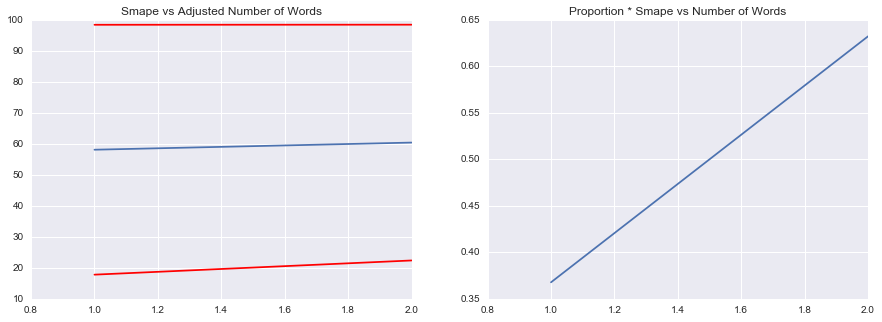

In [36]:
cutoff = 2
page_df['numWords2'] = page_df['numWords']
page_df.loc[page_df.numWords2 > cutoff, 'numWords2'] = cutoff

# Graph statistics for adjusted number of Words.

plt.figure(figsize = doublefigsize)
plt.subplot(121)
bins = np.arange(cutoff + 3)
page_df['numWords2'].hist(bins = bins)
plt.title('Histogram for Adjusted Number of Words for All Data')

errors_df['numWords2'] = page_df.loc[indices['train'], 'numWords2']
cut = pd.cut(errors_df.numWords2, bins)
grouped_df = errors_df.groupby(cut)
means = grouped_df.mean().errors
stds = grouped_df.std().errors
plt.subplot(122)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Mean Errors vs Adjusted Number of Words')
plt.show()

counts = grouped_df.count().errors_smape
means = grouped_df.mean().errors_smape
stds = grouped_df.std().errors_smape
plt.figure(figsize = doublefigsize)
plt.subplot(121)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Smape vs Adjusted Number of Words')

plt.subplot(122)
plt.plot(bins[1:], means * counts / np.sum(counts * means))
plt.title('Proportion * Smape vs Number of Words')
plt.show()

In [37]:
for name in ['train', 'valid', 'tv', 'test', 'train']:
    X[name]['numWords'] = page_df.loc[indices[name], 'numWords2']
    
for name in ['train', 'valid']:
    X[name + '_l']['numWords'] = X[name]['numWords']

timefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, :pastT])),
                          ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 15})) ])
namefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, pastT : pastT + 1])) ])
allfeatures = FeatureUnion([ ('time', timefeatures),
                             ('name', namefeatures) ])

log_predictor = Pipeline([ ('features', allfeatures),
                           ('linear', LinearRegression()) ])

log_predictor.fit(X['train_l'], Y['train_l'])
Y['predict_l'] = log_predictor.predict(X['valid_l'])
Y['predict'] = -param + np.exp(Y['predict_l'])
newsmape = smape(epsilon + Y['predict'], Y['valid'])
print('smape = ', newsmape)

smape =  59.5678102173


### Counts of Numbers in Name

Now let's look at counting the numbers that occur in each name.

In [38]:
# Let's look at number of Numbers.

numNums = []
for name in page_df['name']:
    num = len(re.split(r'\d+', name))
    numNums.append(num)
        
numNums = np.array(numNums)

page_df['numNums'] = numNums

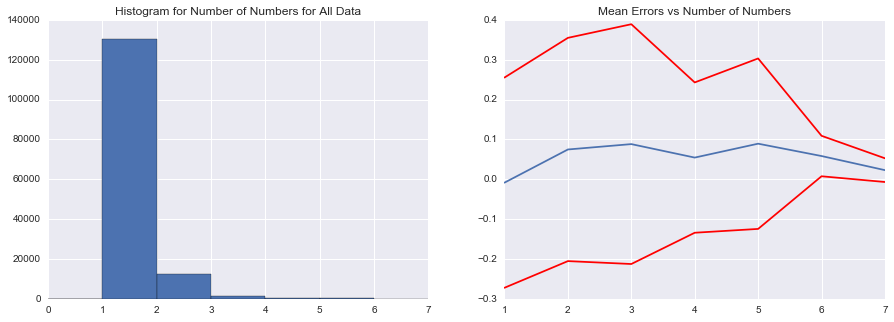

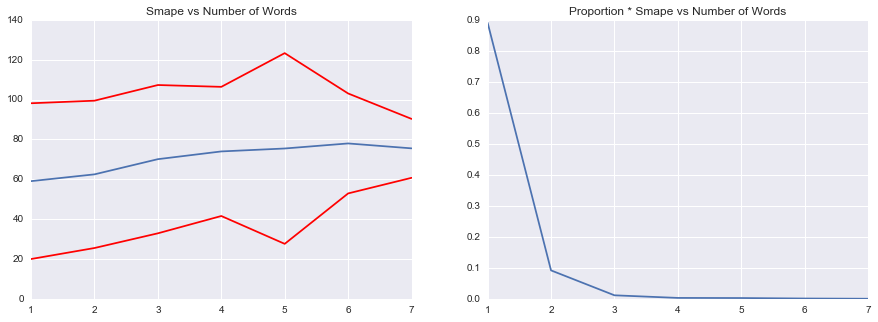

In [39]:
# Let's look at statistics for number of words and how the errors of previous models depend on the number
# of words.

plt.figure(figsize = doublefigsize)
plt.subplot(121)
bins = np.arange(8)
page_df['numNums'].hist(bins = bins)
plt.title('Histogram for Number of Numbers for All Data')

errors_df['numNums'] = page_df.loc[indices['train'], 'numNums']
cut = pd.cut(errors_df.numNums, bins)
grouped_df = errors_df.groupby(cut)
means = grouped_df.mean().errors
stds = grouped_df.std().errors
plt.subplot(122)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Mean Errors vs Number of Numbers')
plt.show()

counts = grouped_df.count().errors_smape
means = grouped_df.mean().errors_smape
stds = grouped_df.std().errors_smape
plt.figure(figsize = doublefigsize)
plt.subplot(121)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Smape vs Number of Words')

plt.subplot(122)
plt.plot(bins[1:], means * counts / np.sum(counts * means))
plt.title('Proportion * Smape vs Number of Words')
plt.show()

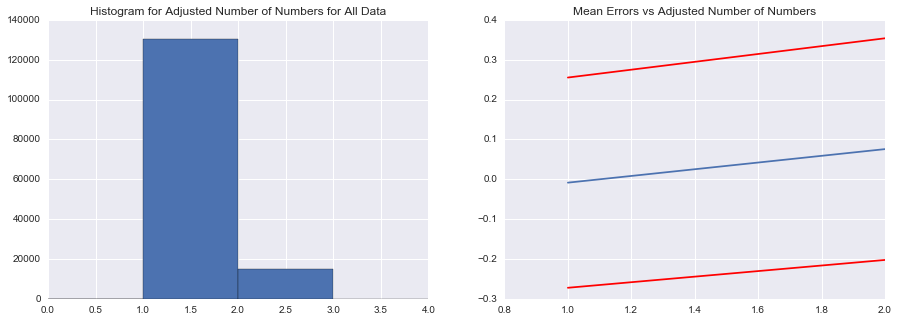

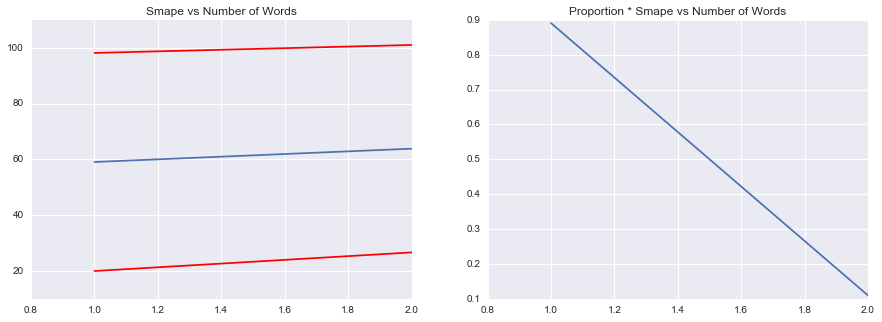

In [40]:
cutoff = 2
page_df['numNums2'] = page_df['numNums']
page_df.loc[page_df.numNums2 > cutoff, 'numNums2'] = cutoff

# Graph statistics for adjusted number of numbers.

plt.figure(figsize = doublefigsize)
plt.subplot(121)
bins = np.arange(cutoff + 3)
page_df['numNums2'].hist(bins = bins)
plt.title('Histogram for Adjusted Number of Numbers for All Data')

errors_df['numNums2'] = page_df.loc[indices['train'], 'numNums2']
cut = pd.cut(errors_df.numNums2, bins)
grouped_df = errors_df.groupby(cut)
means = grouped_df.mean().errors
stds = grouped_df.std().errors
plt.subplot(122)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Mean Errors vs Adjusted Number of Numbers')
plt.show()

counts = grouped_df.count().errors_smape
means = grouped_df.mean().errors_smape
stds = grouped_df.std().errors_smape
plt.figure(figsize = doublefigsize)
plt.subplot(121)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Smape vs Number of Words')

plt.subplot(122)
plt.plot(bins[1:], means * counts / np.sum(counts * means))
plt.title('Proportion * Smape vs Number of Words')
plt.show()

In [41]:
for name in ['train', 'valid', 'tv', 'test', 'train']:
    X[name]['numNums'] = page_df.loc[indices[name], 'numNums']
    
for name in ['train', 'valid']:
    X[name + '_l']['numNums'] = X[name]['numNums']

timefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, :pastT])),
                          ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 15})) ])
namefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, pastT + 1: pastT + 2])) ])

allfeatures = FeatureUnion([ ('time', timefeatures),
                             ('name', namefeatures) ])
linear = LinearRegression()
log_predictor = Pipeline([ ('features', allfeatures),
                           ('linear', linear) ])

log_predictor.fit(X['train_l'], Y['train_l'])
Y['predict_l'] = log_predictor.predict(X['valid_l'])
Y['predict'] = -param + np.exp(Y['predict_l'])
newsmape = smape(epsilon + Y['predict'], Y['valid'])
print('smape = ', newsmape)
print(linear.coef_.mean(axis = 0)[-10:])

smape =  59.810082018
[ 0.05055876  0.05257019 -0.00175802  0.04758455  0.05380851 -0.01029297
  0.0677961  -0.01330389  0.00885455 -0.05272269]


### Size of First Number in Name

Now we extract the first number that appears in the name. We keep track of its size (i.e. itself).

In [42]:
# Let's get size of numbers inside names.

numSize = []
matches = []
for name in page_df['name']:
    match = re.search(r'\d+', name)
    matches.append(match)
    if match != None:
        num = float(match.group())
    else:
        num = 0
    numSize.append(num)

page_df['numSize'] = numSize

We look at a histogram of the positive numbers. We then adjust these values into two categories.

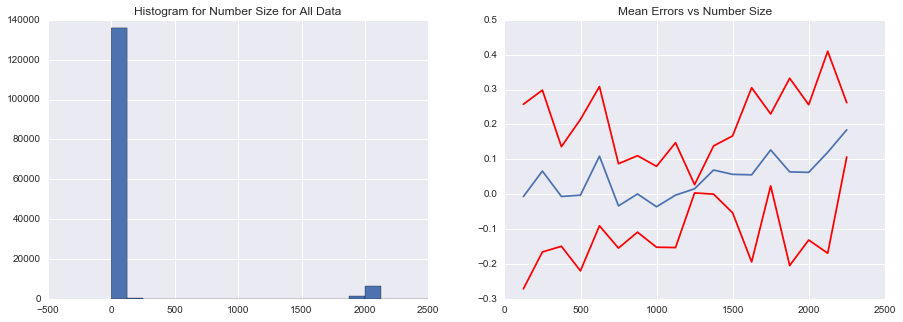

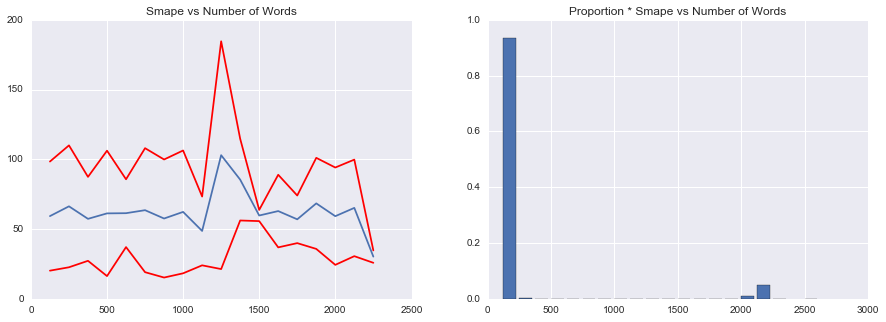

In [43]:
# Let's look at statistics for number of words and how the errors of previous models depend on the number
# of words.

plt.figure(figsize = doublefigsize)
plt.subplot(121)
bins = np.arange(-1, 2.5e3, 2.5e3 / 20)
page_df['numSize'].hist(bins = bins)
plt.title('Histogram for Number Size for All Data')

errors_df['numSize'] = page_df.loc[indices['train'], 'numSize']
cut = pd.cut(errors_df.numSize, bins)
grouped_df = errors_df.groupby(cut)
means = grouped_df.mean().errors
stds = grouped_df.std().errors
plt.subplot(122)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Mean Errors vs Number Size')
plt.show()

counts = grouped_df.count().errors_smape
means = grouped_df.mean().errors_smape
stds = grouped_df.std().errors_smape
plt.figure(figsize = doublefigsize)
plt.subplot(121)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Smape vs Number of Words')

plt.subplot(122)
plt.bar(bins[1:], means * counts / np.sum(counts * means), width = 1e2)
plt.title('Proportion * Smape vs Number of Words')
plt.show()

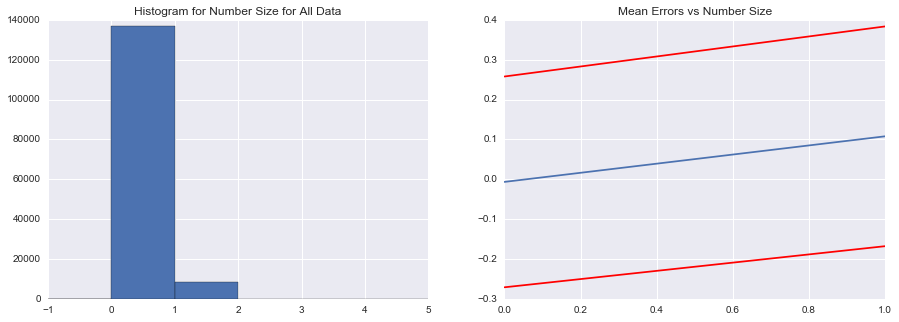

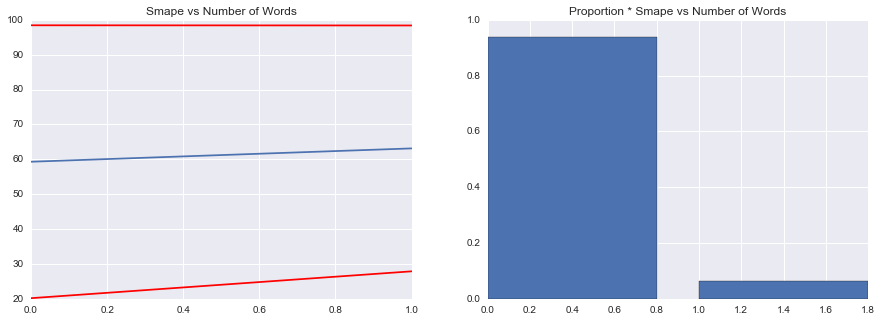

In [44]:
page_df['numSize2'] = page_df.numSize.copy()
mask = page_df.numSize > 0
page_df.loc[mask & (page_df.numSize2 < 1250), 'numSize2'] = 0
page_df.loc[mask & (page_df.numSize2 > 1), 'numSize2'] = 1

plt.figure(figsize = doublefigsize)
plt.subplot(121)
bins = np.arange(-1, 6)
page_df['numSize2'].hist(bins = bins)
plt.title('Histogram for Number Size for All Data')

errors_df['numSize2'] = page_df.loc[indices['train'], 'numSize2']
cut = pd.cut(errors_df.numSize2, bins)
grouped_df = errors_df.groupby(cut)
means = grouped_df.mean().errors
stds = grouped_df.std().errors
plt.subplot(122)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Mean Errors vs Number Size')
plt.show()

counts = grouped_df.count().errors_smape
means = grouped_df.mean().errors_smape
stds = grouped_df.std().errors_smape
plt.figure(figsize = doublefigsize)
plt.subplot(121)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Smape vs Number of Words')

plt.subplot(122)
plt.bar(bins[1:], means * counts / np.sum(counts * means))
plt.title('Proportion * Smape vs Number of Words')
plt.show()

In [45]:
for name in ['train', 'valid', 'tv', 'test', 'train']:
    X[name]['numSize'] = page_df.loc[indices[name], 'numSize2']
    
for name in ['train', 'valid']:
    X[name + '_l']['numSize'] = X[name]['numSize']

timefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, :pastT])),
                          ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 15})) ])
namefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, pastT + 2: pastT + 3])) ])

allfeatures = FeatureUnion([ ('time', timefeatures),
                             ('name', namefeatures) ])
linear = LinearRegression()
log_predictor = Pipeline([ ('features', allfeatures),
                           ('linear', linear) ])

log_predictor.fit(X['train_l'], Y['train_l'])
Y['predict_l'] = log_predictor.predict(X['valid_l'])
Y['predict'] = -param + np.exp(Y['predict_l'])
newsmape = smape(epsilon + Y['predict'], Y['valid'])
print('smape = ', newsmape)

smape =  59.8908272801


### Acronym Count

Let's count the number of capital letters that occur in a sequence of two or more capital letters. This roughly gives a count of the number of letters that occur in acronyms.

In [46]:
# Let's look at number of consecutive capital letters (like in an acronym).

capNums = []
matches = []
for name in page_df['name']:
    match = re.findall(r'[A-Z][A-Z]+', name)
    matches.append(match)
    num = 0
    for s in match:
        num += len(s)
    capNums.append(num)
    
page_df['capNums'] = capNums

page_df.loc[[0, 4, 6, 8], ['name', 'capNums']]

,name,capNums
0,2NE1,2
4,52_Hz_I_Love_You,0
6,91Days,0
8,AKB48,3


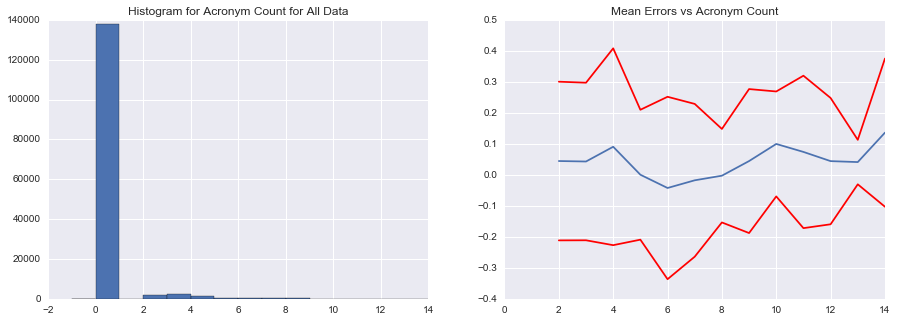

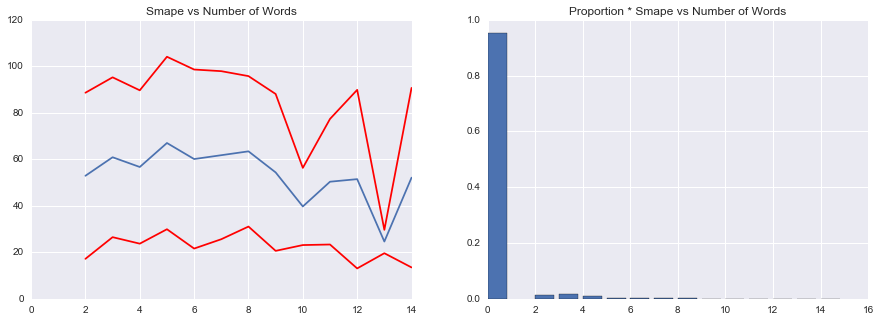

In [47]:
# Let's look at statistics for number of words and how the errors of previous models depend on the number
# of words.

plt.figure(figsize = doublefigsize)
plt.subplot(121)
bins = np.arange(-1, 15)
page_df['capNums'].hist(bins = bins)
plt.title('Histogram for Acronym Count for All Data')

errors_df['capNums'] = page_df.loc[indices['train'], 'capNums']
cut = pd.cut(errors_df.capNums, bins)
grouped_df = errors_df.groupby(cut)
means = grouped_df.mean().errors
stds = grouped_df.std().errors
plt.subplot(122)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Mean Errors vs Acronym Count')
plt.show()

counts = grouped_df.count().errors_smape
means = grouped_df.mean().errors_smape
stds = grouped_df.std().errors_smape
plt.figure(figsize = doublefigsize)
plt.subplot(121)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Smape vs Number of Words')

plt.subplot(122)
plt.bar(bins[1:], means * counts / np.sum(counts * means))
plt.title('Proportion * Smape vs Number of Words')
plt.show()

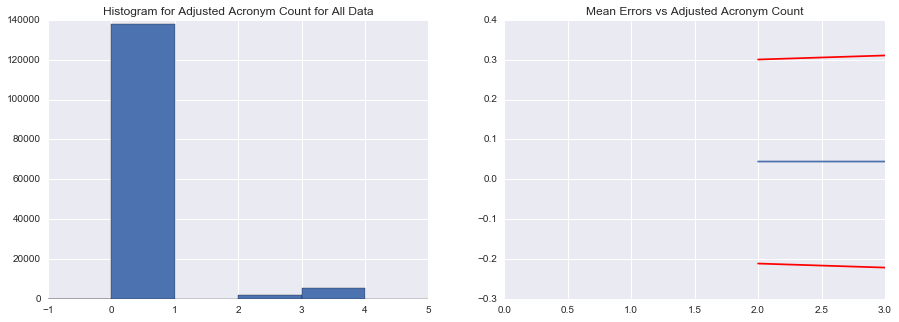

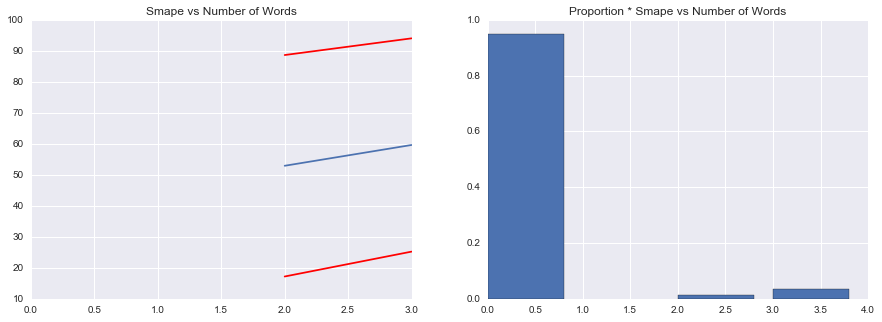

In [48]:
cutoff = 3
page_df['capNums2'] = page_df.capNums
page_df.loc[page_df.capNums2 > cutoff, 'capNums2'] = cutoff

plt.figure(figsize = doublefigsize)
plt.subplot(121)
bins = np.arange(-1, cutoff + 3)
page_df['capNums2'].hist(bins = bins)
plt.title('Histogram for Adjusted Acronym Count for All Data')

errors_df['capNums2'] = page_df.loc[indices['train'], 'capNums2']
cut = pd.cut(errors_df.capNums2, bins)
grouped_df = errors_df.groupby(cut)
means = grouped_df.mean().errors
stds = grouped_df.std().errors
plt.subplot(122)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Mean Errors vs Adjusted Acronym Count')
plt.show()

counts = grouped_df.count().errors_smape
means = grouped_df.mean().errors_smape
stds = grouped_df.std().errors_smape
plt.figure(figsize = doublefigsize)
plt.subplot(121)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Smape vs Number of Words')

plt.subplot(122)
plt.bar(bins[1:], means * counts / np.sum(counts * means))
plt.title('Proportion * Smape vs Number of Words')
plt.show()

In [49]:
for name in ['train', 'valid', 'tv', 'test', 'train']:
    X[name]['capNums'] = page_df.loc[indices[name], 'capNums2']
    
for name in ['train', 'valid']:
    X[name + '_l']['capNums'] = X[name]['capNums']

timefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, :pastT])),
                          ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 15})) ])
namefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, pastT + 3 : pastT + 4])) ])

allfeatures = FeatureUnion([ ('time', timefeatures),
                             ('name', namefeatures) ])
linear = LinearRegression()
log_predictor = Pipeline([ ('features', allfeatures),
                           ('linear', linear) ])

log_predictor.fit(X['train_l'], Y['train_l'])
Y['predict_l'] = log_predictor.predict(X['valid_l'])
Y['predict'] = -param + np.exp(Y['predict_l'])
newsmape = smape(epsilon + Y['predict'], Y['valid'])
print('smape = ', newsmape)

smape =  59.6273178


### Largest Word Length

In [50]:
# Let's look at largest word length

wordLengths = []
for name in page_df['name']:
    words = re.split(r'_|\d+', name)
    matches.append(match)
    if words:
        lengths = np.array([len(x) for x in words])
        wordLengths.append(np.amax(lengths))
    else:
        wordLengths.append(0)
    
# put into data frame

page_df['wordLength'] = wordLengths
page_df.loc[[0, 4, 6, 8], ['name', 'wordLength']]

,name,wordLength
0,2NE1,2
4,52_Hz_I_Love_You,4
6,91Days,4
8,AKB48,3


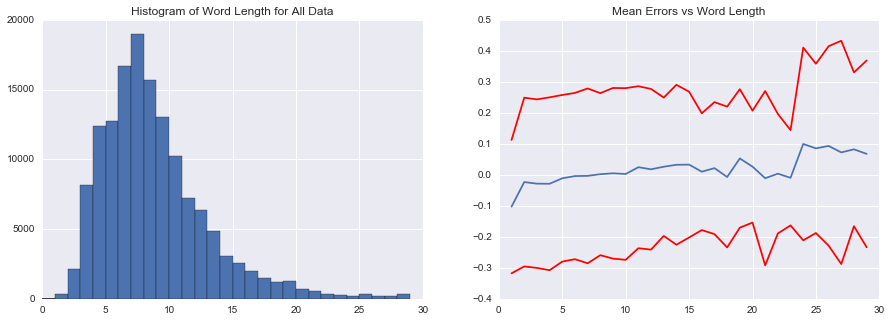

In [51]:
# Let's look at statistics for number of words and how the errors of previous models depend on the number
# of words.

plt.figure(figsize = doublefigsize)
plt.subplot(121)
bins = np.arange(30)
page_df['wordLength'].hist(bins = bins)
plt.title('Histogram of Word Length for All Data')

errors_df['wordLength'] = page_df.loc[indices['train'], 'wordLength']
cut = pd.cut(errors_df.wordLength, bins)
grouped_df = errors_df.groupby(cut)
means = grouped_df.mean().errors
stds = grouped_df.std().errors
plt.subplot(122)
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + stds, color = 'red')
plt.plot(bins[1:], means - stds, color = 'red')
plt.title('Mean Errors vs Word Length')
plt.show()

In [52]:
page_df['wordLength2'] = np.log(1 + page_df.wordLength)

In [53]:
for name in ['train', 'valid', 'tv', 'test', 'train']:
    X[name]['wordLength'] = page_df.loc[indices[name], 'wordLength2']
    
for name in ['train', 'valid']:
    X[name + '_l']['wordLength'] = X[name]['wordLength']

timefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, :pastT])),
                          ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 15})) ])
namefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, -1 : ])) ])

allfeatures = FeatureUnion([ ('time', timefeatures),
                             ('name', namefeatures) ])
linear = LinearRegression()
log_predictor = Pipeline([ ('features', allfeatures),
                           ('linear', linear) ])

log_predictor.fit(X['train_l'], Y['train_l'])
Y['predict_l'] = log_predictor.predict(X['valid_l'])
Y['predict'] = -param + np.exp(Y['predict_l'])
newsmape = smape(epsilon + Y['predict'], Y['valid'])
print('smape = ', newsmape)

smape =  59.6530416362


## All Important Name Features

In [54]:
X['train_l'].head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,numWords,numNums,numSize,capNums,wordLength
122897,7.545125,8.639676,9.165081,9.068258,9.919828,9.803087,9.218457,9.004607,8.661899,8.621643,...,7.178927,7.077920,7.055744,6.985179,6.871610,2,1,0.0,0,1.791759
138730,3.349904,3.314186,3.540959,3.650658,3.314186,3.540959,3.511545,3.449988,3.540959,3.511545,...,3.540959,3.676301,3.772761,3.676301,3.417727,2,1,0.0,0,2.708050
55662,5.236520,5.236520,5.236520,5.236520,5.236520,5.236520,5.236520,5.236520,5.236520,5.236520,...,4.182050,4.388257,4.297285,4.297285,4.460144,2,2,0.0,0,2.302585
101069,6.624063,6.624063,6.624063,6.624063,6.624063,6.624063,6.624063,6.624063,6.624063,6.624063,...,5.622211,5.708770,5.491002,5.625821,6.219596,2,1,0.0,0,2.397895
53806,5.865051,5.265278,6.110358,6.019809,5.821566,6.225548,7.308878,5.725218,6.017376,5.951944,...,4.483003,4.705016,4.629863,4.483003,5.543222,2,1,0.0,0,2.079442


In [62]:
timefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, :pastT])),
                          ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 5})) ])
namefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, pastT : ])) ])

allfeatures = FeatureUnion([ ('time', timefeatures),
                             ('name', namefeatures) ])
linear = LinearRegression()
log_predictor = Pipeline([ ('features', allfeatures),
                           ('linear', linear) ])

log_predictor.fit(X['train_l'].drop('numNums', axis = 1), Y['train_l'])
Y['predict_l'] = log_predictor.predict(X['valid_l'].drop('numNums', axis = 1))
Y['predict'] = -param + np.exp(Y['predict_l'])
newsmape = smape(epsilon + Y['predict'], Y['valid'])
print('smape = ', newsmape)

smape =  60.8426256203


0.0002 , 0.0004 , 0.0006 , 0.0008 , 0.001 , 0.0012 , 

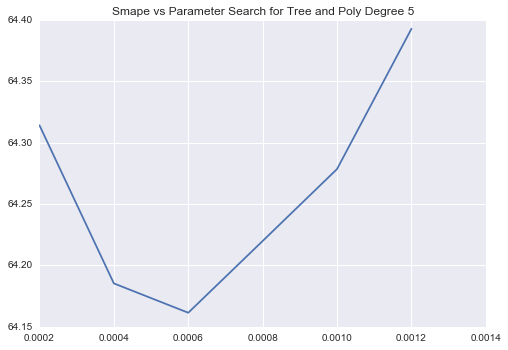

In [65]:
# Tree

timefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, :pastT])),
                          ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 5})) ])
namefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, pastT : ])) ])

allfeatures = FeatureUnion([ ('time', timefeatures),
                             ('name', namefeatures) ])
tree = DecisionTreeRegressor(max_depth = 13)
log_predictor = Pipeline([ ('features', allfeatures),
                           ('tree', tree) ])

search = 2 * 10**-4 * np.arange(1.0, 7.0, 1.0)
results = []

for var in search:
    
    log_predictor.set_params(tree__min_samples_leaf = var)
    log_predictor.fit(X['train_l'], Y['train_l'])
    Y['predict_l'] = log_predictor.predict(X['valid_l'])
    Y['predict'] = -param + np.exp(Y['predict_l'])
    newsmape = smape(epsilon + Y['predict'], Y['valid'])
    results.append(newsmape)
    print(var, ', ', end = '')
    
plt.plot(search, results)
plt.title('Smape vs Parameter Search for Tree and Poly Degree 5')
plt.show()

0.7 , 0.8 , 0.9 , 1.0 , 1.1 , 1.2 , 

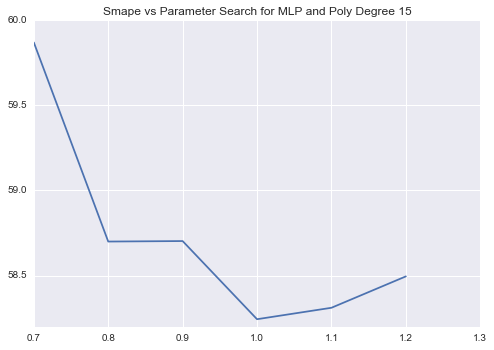

In [79]:
timefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, :pastT])),
                          ('features', FunctionTransformer(features['polymodel'],
                                                            kw_args = {'windowSize' : 31,
                                                                       'degree' : 15})) ])
namefeatures = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, pastT : ])) ])

allfeatures = FeatureUnion([ ('time', timefeatures),
                             ('name', namefeatures) ])
neural = MLPRegressor( hidden_layer_sizes = (50, 120, 10),
                       learning_rate = 'adaptive', verbose = True)

log_predictor = Pipeline([ ('features', allfeatures),
                           ('scaler', StandardScaler()),
                           ('neural', MLPRegressor(hidden_layer_sizes = (30, 30, 30),
                                                   tol = 1e-3,
                                                   random_state = 123)) ])

search = 10**-1 * np.arange(7.0, 13.0, 1.0)
results = []

for var in search:
    
    log_predictor.set_params(neural__alpha = var)
    log_predictor.fit(X['train_l'], Y['train_l'])
    Y['predict_l'] = log_predictor.predict(X['valid_l'])
    Y['predict'] = -param + np.exp(Y['predict_l'])
    newsmape = smape(epsilon + Y['predict'], Y['valid'])
    results.append(newsmape)
    print(var, ', ', end = '')
    
plt.plot(search, results)
plt.title('Smape vs Parameter Search for MLP and Poly Degree 15')
plt.show()